# Q1. Install MLflow

In [7]:

!mlflow --version

mlflow, version 2.3.2


> Answer: 2.3.2

# Q2. Download and preprocess the data

(Files already downloaded before I started writing this notebook so I don't include the code here)

What's the size of the saved DictVectorizer file?

In [8]:
!pwd

/home/ubuntu/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/homework


In [12]:
!ls -ltr output

total 7104
-rw-rw-r-- 1 ubuntu ubuntu  153660 May 25 10:51 dv.pkl
-rw-rw-r-- 1 ubuntu ubuntu 2336393 May 25 10:51 val.pkl
-rw-rw-r-- 1 ubuntu ubuntu 2146163 May 25 10:51 train.pkl
-rw-rw-r-- 1 ubuntu ubuntu 2632817 May 25 10:51 test.pkl


> Answer: 154 KB

# Q3. Train a model with autolog

In [74]:
# Modified `train.py`
!cat train.py

import os
import pickle
import click

import argparse
import mlflow

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)

# @click.command()
# @click.option(
#     "--data_path",
#     default="./output",
#     help="Location where the processed NYC taxi trip data was saved"
# )


def run_train(data_path: str):

    # start mlflow
    with mlflow.start_run():
        # use autolog
        mlflow.sklearn.autolog()

        X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
        X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

        rf = RandomForestRegressor(max_depth=10, random_state=0)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)

        rmse = mean_squared_error(y_val, y_pred, squared=False)


if __name__ == '__main__':

    # Setting the tracking_uri for mlflow
    mlflow.

In [30]:
!python train.py

2023/05/25 11:50:12 INFO mlflow.tracking.fluent: Experiment with name 'green-taxi_experiment' does not exist. Creating a new experiment.
2023/05/25 11:50:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [31]:
from mlflow.tracking import MlflowClient

# TRACKING_URI = "sqlite:///..//mlflow.db"
TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=TRACKING_URI)

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


In [32]:

client.search_experiments()

[<Experiment: artifact_location='/home/ubuntu/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/homework/mlruns/1', creation_time=1685015412880, experiment_id='1', last_update_time=1685015412880, lifecycle_stage='active', name='green-taxi_experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1685013002876, experiment_id='0', last_update_time=1685013002876, lifecycle_stage='active', name='Default', tags={}>]

In [33]:
client.search_runs(experiment_ids=1)

[<Run: data=<RunData: metrics={'training_mean_absolute_error': 1.4846553814437824,
  'training_mean_squared_error': 3.785599387209934,
  'training_r2_score': 0.2905920668431764,
  'training_root_mean_squared_error': 1.9456616836464489,
  'training_score': 0.2905920668431764}, params={'bootstrap': 'True',
  'ccp_alpha': '0.0',
  'criterion': 'squared_error',
  'max_depth': '10',
  'max_features': '1.0',
  'max_leaf_nodes': 'None',
  'max_samples': 'None',
  'min_impurity_decrease': '0.0',
  'min_samples_leaf': '1',
  'min_samples_split': '2',
  'min_weight_fraction_leaf': '0.0',
  'n_estimators': '100',
  'n_jobs': 'None',
  'oob_score': 'False',
  'random_state': '0',
  'verbose': '0',
  'warm_start': 'False'}, tags={'estimator_class': 'sklearn.ensemble._forest.RandomForestRegressor',
  'estimator_name': 'RandomForestRegressor',
  'mlflow.log-model.history': '[{"run_id": "36be14d49c284d1d9e170b4e93be26ca", '
                              '"artifact_path": "model", "utc_time_created": '

In [34]:
run_id = '36be14d49c284d1d9e170b4e93be26ca'
run = client.get_run(run_id=run_id)

In [35]:
run.data.params

{'bootstrap': 'True',
 'ccp_alpha': '0.0',
 'criterion': 'squared_error',
 'max_depth': '10',
 'max_features': '1.0',
 'max_leaf_nodes': 'None',
 'max_samples': 'None',
 'min_impurity_decrease': '0.0',
 'min_samples_leaf': '1',
 'min_samples_split': '2',
 'min_weight_fraction_leaf': '0.0',
 'n_estimators': '100',
 'n_jobs': 'None',
 'oob_score': 'False',
 'random_state': '0',
 'verbose': '0',
 'warm_start': 'False'}

> Answer: max_depth = 10

# Q4. Tune hyperparameters

Now let's try to reduce the validation error by tuning the hyperparameters of the RandomForestRegressor using optuna. We have prepared the script hpo.py for this exercise.

Your task is to modify the script hpo.py and make sure that the validation RMSE is logged to the tracking server for each run of the hyperparameter optimization (you will need to add a few lines of code to the objective function) and run the script without passing any parameters.

After that, open UI and explore the runs from the experiment called random-forest-hyperopt to answer the question below.

The idea is to just log the information that you need to answer the question below, including:

the list of hyperparameters that are passed to the objective function during the optimization,
the RMSE obtained on the validation set (February 2022 data).
What's the best validation RMSE that you got?

- 1.85  
- 2.15  
- 2.45  
- 2.85  

In [43]:
# modified script to enable mlflow logging
!cat hpo.py

import os
import pickle
import click
import mlflow
import optuna

from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import argparse

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("random-forest-hyperopt")


def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


# @click.command()
# @click.option(
#     "--data_path",
#     default="./output",
#     help="Location where the processed NYC taxi trip data was saved"
# )
# @click.option(
#     "--num_trials",
#     default=10,
#     help="The number of parameter evaluations for the optimizer to explore"
# )

def run_optimization(data_path: str = "./output", num_trials: int = 10):

    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    def objective(trial):
        params = {
            'n_estima

In [44]:
# !pip install optuna

In [45]:
# run the script
!python hpo.py

[I 2023-05-25 12:52:35,974] A new study created in memory with name: no-name-c260b847-f7f2-4d17-aada-4b6610d8b3e3
[I 2023-05-25 12:52:38,279] Trial 0 finished with value: 2.451379690825458 and parameters: {'n_estimators': 25, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 2.451379690825458.
[I 2023-05-25 12:52:38,535] Trial 1 finished with value: 2.4667366020368333 and parameters: {'n_estimators': 16, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 2.451379690825458.
[I 2023-05-25 12:52:40,639] Trial 2 finished with value: 2.449827329704216 and parameters: {'n_estimators': 34, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 2.449827329704216.
[I 2023-05-25 12:52:41,251] Trial 3 finished with value: 2.460983516558473 and parameters: {'n_estimators': 44, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 2.44982732

In [46]:
client.search_experiments()

[<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1685018964797, experiment_id='2', last_update_time=1685018964797, lifecycle_stage='active', name='random-forest-hyperopt', tags={}>,
 <Experiment: artifact_location='/home/ubuntu/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/homework/mlruns/1', creation_time=1685015412880, experiment_id='1', last_update_time=1685015412880, lifecycle_stage='active', name='green-taxi_experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1685013002876, experiment_id='0', last_update_time=1685013002876, lifecycle_stage='active', name='Default', tags={}>]

In [47]:
best_runs = client.search_runs(
    experiment_ids=2,
    filter_string="",
    max_results=3,
    order_by=["metrics.rmse ASC"]
)

In [49]:

for run in best_runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['validation_rmse']:.4f}")

run id: 658d2d7e3f694a16ad6805ddfcb506a2, rmse: 2.4861
run id: 994f24556b094542b280fa5655963614, rmse: 2.4560
run id: 1fa54aaea30b43219fc2132f38008d24, rmse: 2.5374


> Answer: Best validation RMSE = 2.45

## Q5. Promote the best model to the model registry

In [75]:
# Modified register_model.py so that it selects the model with the lowest RMSE on the test set
!cat register_model.py

import os
import pickle
import click
import mlflow
import argparse

from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from hyperopt import hp, space_eval
from hyperopt.pyll import scope

HPO_EXPERIMENT_NAME = "random-forest-hyperopt"
EXPERIMENT_NAME = "random-forest-best-models"
# RF_PARAMS = ['max_depth', 'n_estimators', 'min_samples_split', 'min_samples_leaf', 'random_state', 'n_jobs']

RF_PARAMS = {
    'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
    'random_state': 42,
    'n_jobs': -1
}

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog()


def load_pickle(

In [71]:
!python register_model.py

2023/05/25 14:09:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
Registered model 'random-forest-model' already exists. Creating a new version of this model...
2023/05/25 14:09:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: random-forest-model, version 4
Created version '4' of model 'random-forest-model'.


In [72]:
# get run_id from version 1 of 'greentaxi_regressor'

version_1_run_id = client.get_model_version(name = "random-forest-model", version = 4).run_id
run_ver1 = client.get_run(run_id=version_1_run_id)

In [73]:

print(f"Version 1 Test RMSE: {round(run_ver1.data.metrics['test_rmse'],2)}")

Version 1 Test RMSE: 2.29


>Answer: Best RMSE is 2.29. Closest answer in submission form is 2.185

# Q6. Model metadata

Now explore your best model in the model registry using UI. What information does the model registry contain about each model?

- Version number  
- Source experiment  
- Model signature  
- All the above answers are correct  

The only one I can see is the model signature, near the bottom:

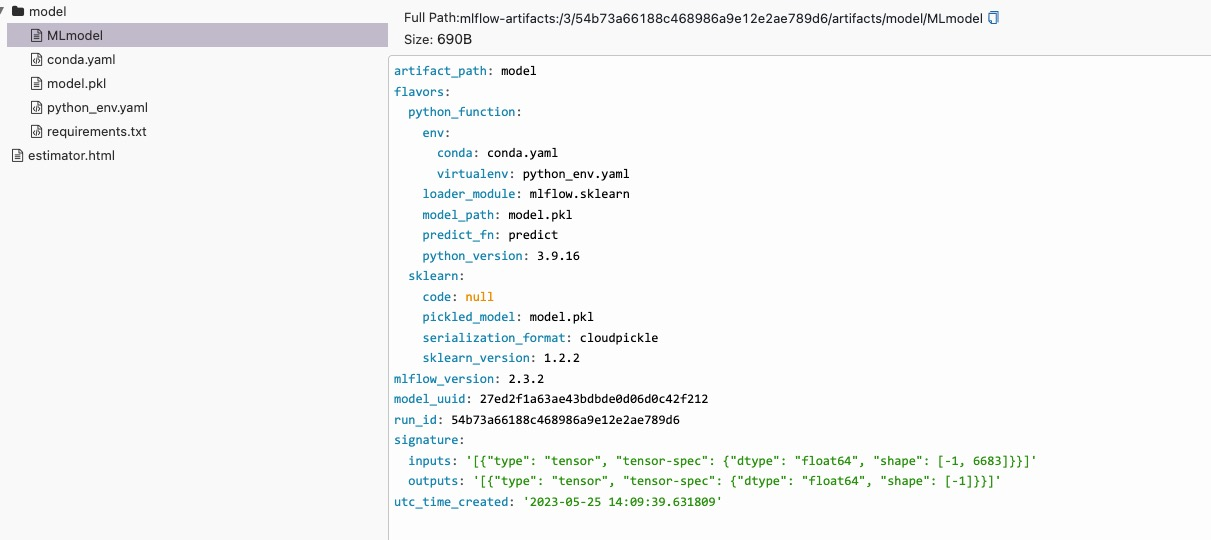

> Answer: Model signature